In [1]:
import argparse
import os
import pickle
import skimage
from skimage import data, color, exposure
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# functions are loaded here so lesson_functions are not needed
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import glob
from skimage.feature import hog
from scipy.ndimage.measurements import label
import argparse

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Functions

In [25]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# Define a function to compute color histogram features  
def color_hist_RGB(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_SH(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            change_cspace = "cv2.COLOR_RGB2" + cspace
            feature_image = cv2.cvtColor(image, eval(change_cspace))
        else: feature_image = np.copy(image)      
            
        # Get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Get color histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Get HoG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append features
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        #features.append(np.concatenate((hist_features,hog_features)))
        
    return features
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
# Heatmap
def add_heat(heatmap_image, windows):
    #global heatmap_image
    
    for window in hot_windows:
        #print(window[0][1],window[1][1], window[0][0],window[1][0])
        heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5
        #print(heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]][0][:3])
    
    #plt.imshow(heatmap_img)

    return heatmap_image
# Threshold image
def apply_threshold(heatmap, threshold):
    new_heatmap = np.copy(heatmap)
    # Zero out pixels below the threshold
    new_heatmap[new_heatmap <= threshold] = 0
    # Return thresholded map
    return new_heatmap
# Draw boxes around label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #print(nonzero[0][0], nonzero[1][0])
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Data Loading

In [3]:
cars = glob.glob("./vehicles/*/*/*.png")
notcars = glob.glob("./non-vehicles/*/*/*.png")

### Data Exploration

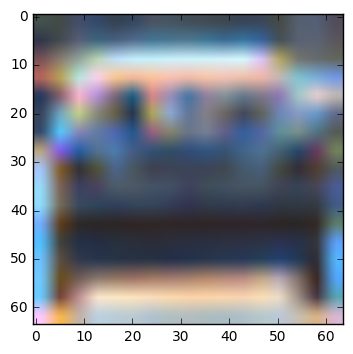

In [16]:
#mpimg.imread(cars[1])
plt.imshow(mpimg.imread(cars[100]))

In [36]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
small_img = cv2.resize(image, (32, 32))
print(small_img.shape)
print (image.shape)
#(32, 32, 3)

(32, 32, 3)
(64, 64, 3)


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


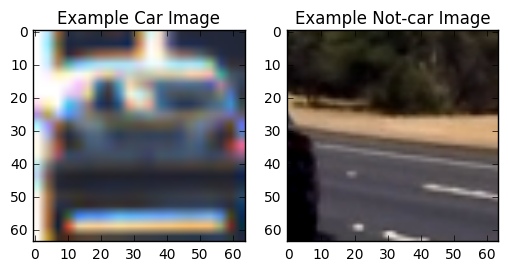

In [18]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

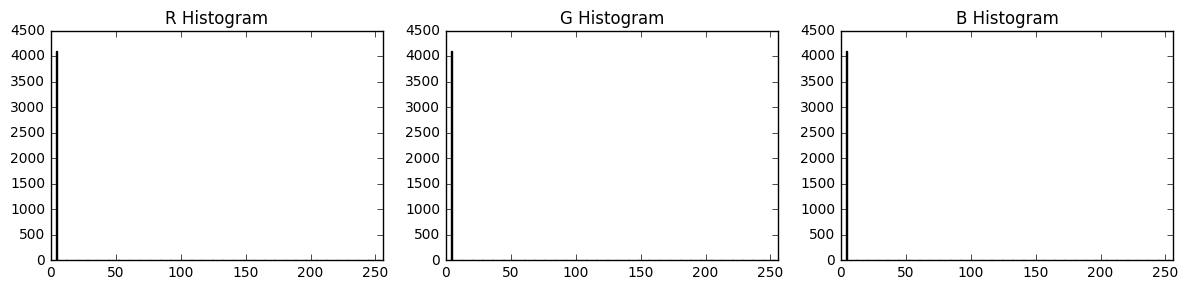

In [35]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
    
rh, gh, bh, bincen, feature_vec = color_hist_RGB(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

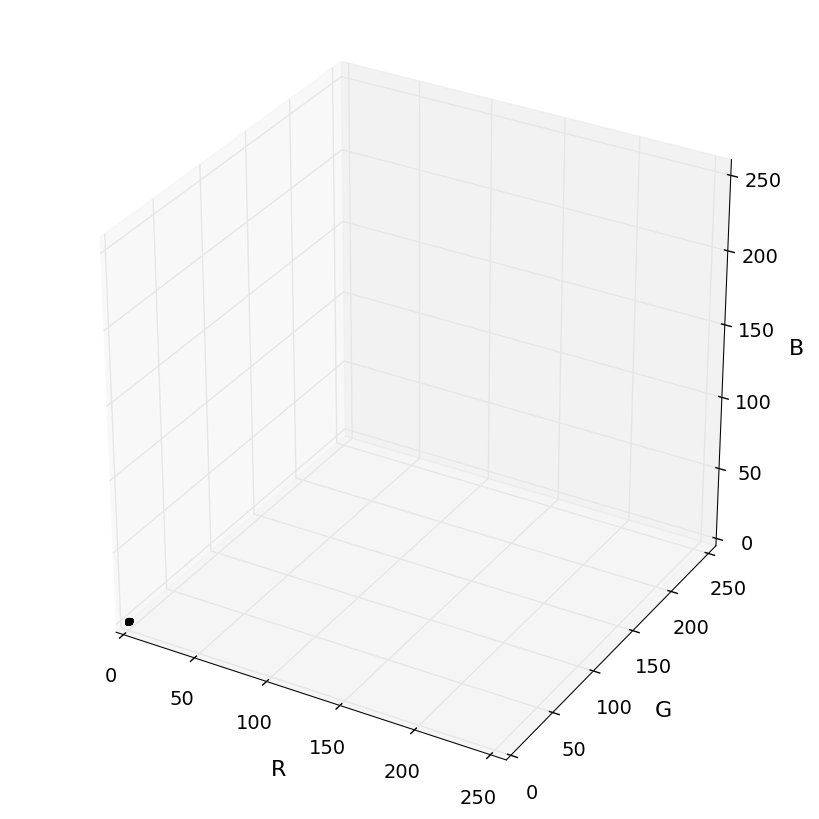

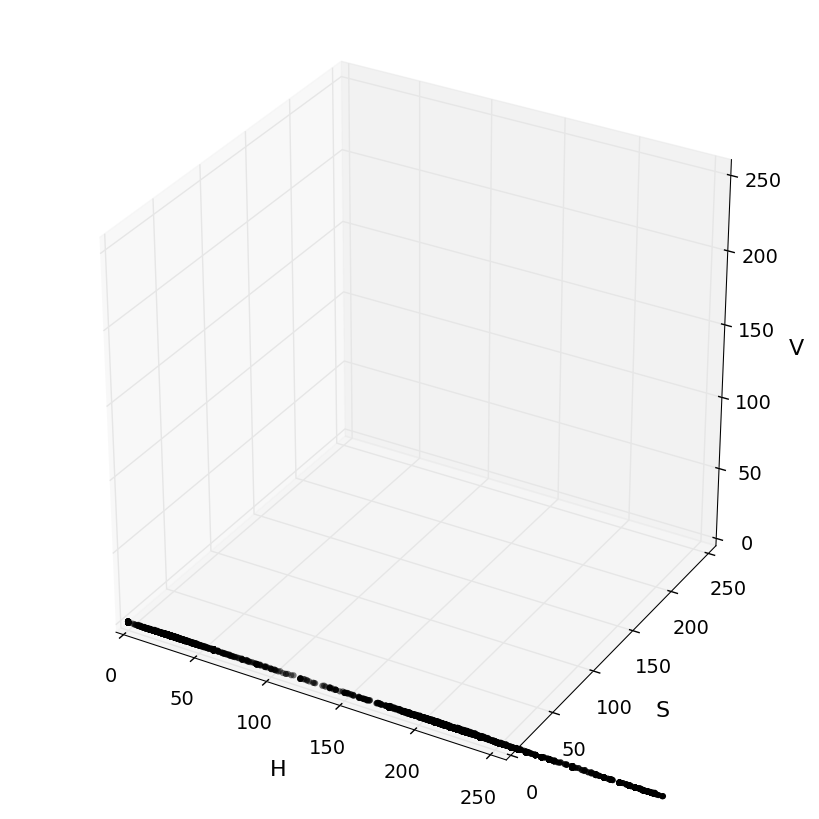

In [34]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
img = mpimg.imread(cars[ind])

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

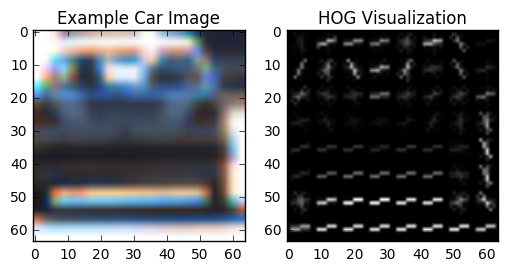

In [19]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

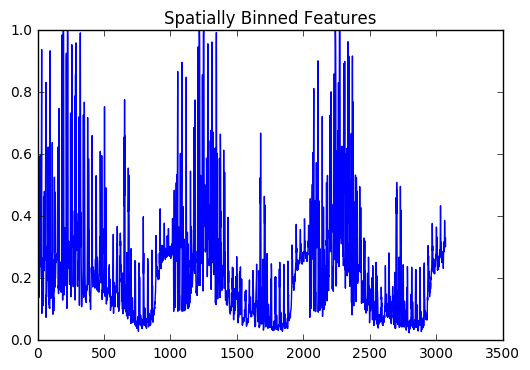

In [37]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
feature_vec = bin_spatial(image,size=(32, 32))
# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

#### Color Classify: Based on spatial and histogram only

In [6]:
car_features = extract_features_SH(cars, cspace='RGB', spatial_size=(32, 32),hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features_SH(notcars, cspace='RGB', spatial_size=(32, 32),hist_bins=32, hist_range=(0, 256))

In [7]:
### Create training and test set

# Array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=12412)
X_train, y_train = shuffle(X_train, y_train, random_state=2342)

In [9]:
# performs under different binning scenarios
spatial = 35
histbin = 35
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC based on spatial and histogram only= ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 35 and 35 histogram bins
Feature vector length: 3168
30.41 Seconds to train SVC...
Test Accuracy of SVC based on spatial and histogram only=  0.9155
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  1.]
0.01046 Seconds to predict 10 labels with SVC


#### HOG classify

In [40]:
### play with the parameters colorspace, orient,pix_per_cell, cell_per_block, and hog_channel to get a feel for what 
###combination of parameters give the best results.Tweak these parameters and see how the results change.
color_space= 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

In [11]:
%%time
### Obtain features

# Get features for car images
car_features = extract_features(cars, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)


# Get features for non-car images
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

CPU times: user 59.7 s, sys: 484 ms, total: 1min
Wall time: 1min 51s


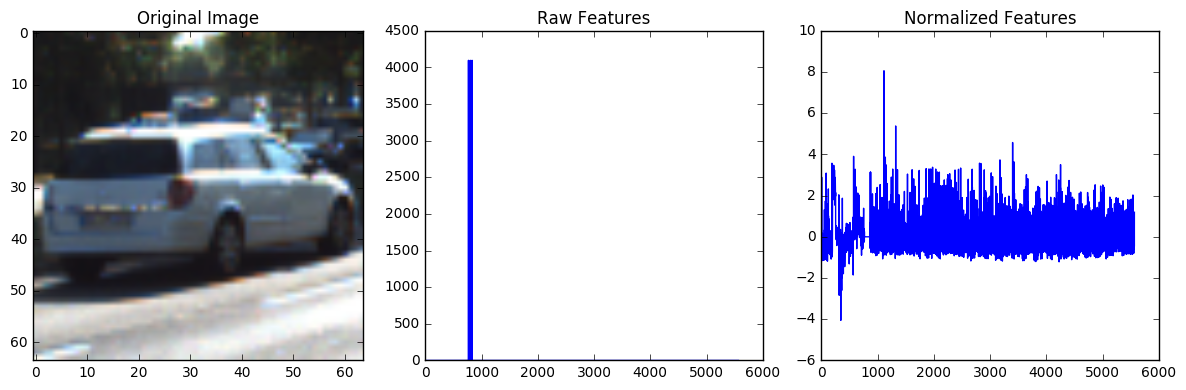

In [12]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [13]:
### Create training and test set

# Array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=12412)
X_train, y_train = shuffle(X_train, y_train, random_state=2342)

In [14]:
%%time
# Use a linear SVC 
svc = LinearSVC(C=1.0)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of HOG based SVC = ', round(svc.score(X_test, y_test), 4))

14.53 Seconds to train SVC...
Test Accuracy of HOG based SVC =  0.9885
CPU times: user 10.5 s, sys: 296 ms, total: 10.8 s
Wall time: 14.6 s


In [15]:
print('Using spatial binning of:',spatial_size,'and',hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (16, 16) and 32 histogram bins
Feature vector length: 5568
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  1.]
0.03799 Seconds to predict 10 labels with SVC


##### ^^^ HOG classification has better accuracy of 98% than color color classification

In [46]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

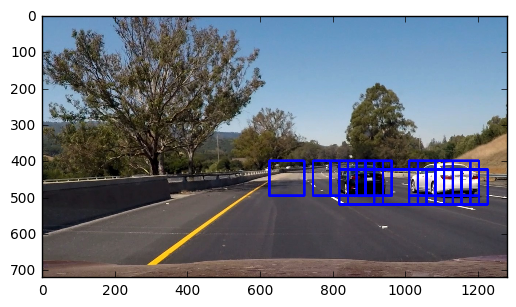

In [47]:
ystart = 400
ystop = 656
scale = 1.5

img = mpimg.imread('./CarND-Vehicle-Detection-master/test_images/test6.jpg')
draw_img = np.copy(img)
img = img.astype(np.float32)/255
img_tosearch = img[ystart:ystop,:,:]
ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
if scale != 1:
    imshape = ctrans_tosearch.shape
    ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
ch1 = ctrans_tosearch[:,:,0]
ch2 = ctrans_tosearch[:,:,1]
ch3 = ctrans_tosearch[:,:,2]
# Define blocks and steps as above
nxblocks = (ch1.shape[1] // pix_per_cell)-1
nyblocks = (ch1.shape[0] // pix_per_cell)-1 
nfeat_per_block = orient*cell_per_block**2
# 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
window = 64
nblocks_per_window = (window // pix_per_cell)-1 
cells_per_step = 2  # Instead of overlap, define how many cells to step
nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
nysteps = (nyblocks - nblocks_per_window) // cells_per_step
 
# Compute individual channel HOG features for the entire image
hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
for xb in range(nxsteps):
    for yb in range(nysteps):
        ypos = yb*cells_per_step
        xpos = xb*cells_per_step
        # Extract HOG for this patch
        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        # Extract the image patch
        subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
        #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)
          
        if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
plt.imshow(draw_img)

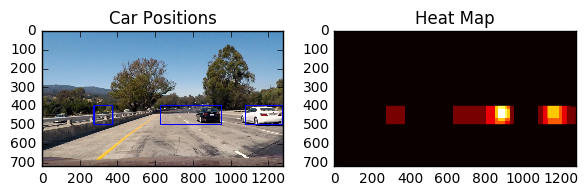

In [48]:
# Read in image similar to one shown above 
image = mpimg.imread('./CarND-Vehicle-Detection-master/test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

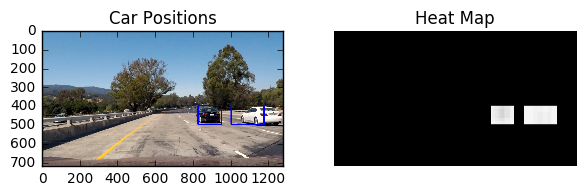

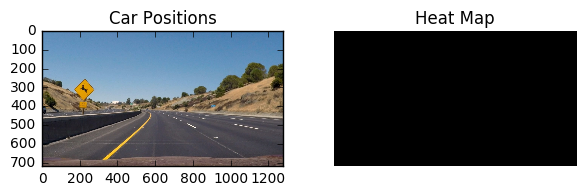

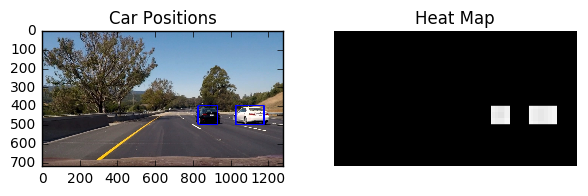

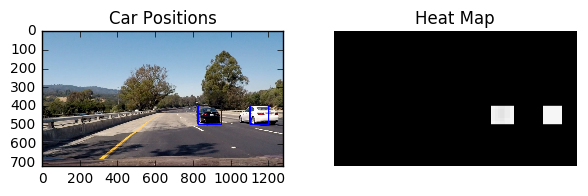

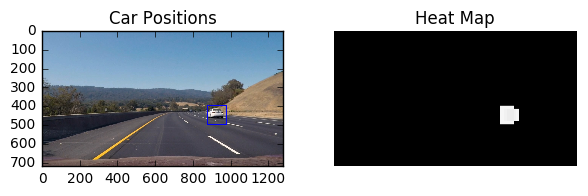

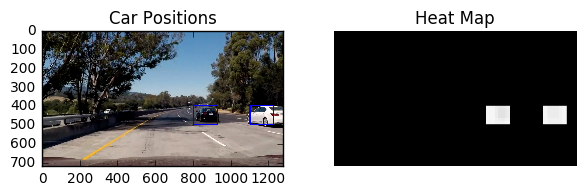

In [43]:
### Test Sliding Window on test images
images = glob.glob('CarND-Vehicle-Detection-master/test_images/test*.jpg')
fig = plt.figure(figsize=(30, 10))
for i in range(len(images)):
    
    car_image = mpimg.imread(images[i])
    car_image = car_image.astype(np.float32)/255


    windows = slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(64,64), xy_overlap=(0.75, 0.75))

    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(140,140), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[460, 580], 
    
    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(car_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    
    heat = np.zeros_like(car_image)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, 5)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heat)
    image = draw_labeled_bboxes(mpimg.imread(images[i]), labels)
   
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.axis('off')

### Cars Finding

In [44]:
### Video pipeline
def process_video(image):
    global heat, heat_list
    car_image = image.astype(np.float32)/255
    heatmap_factor = 0.9

    windows = slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(64,64), xy_overlap=(0.75, 0.75))

    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(140,140), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[460, 580], 
    
    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(car_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    
    heat_list.append(hot_windows)
    
    # Create heatmap
    heat_image = np.zeros_like(car_image)
    
    if len(heat_list) > 15:
        heat_list.pop(0)
        for hot_window in heat_list:
            for window in hot_windows:
                heat_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5
    elif len(heat_list) < 15:
        for window in hot_windows:
            heat_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5

    
    heat_image = cv2.GaussianBlur(heat_image,(5,5),0)
    
    heat_image = apply_threshold(heat_image, 5) #4
    
    
    if heat == None:
        heat = heat_image
    else:
        #heat_image = heat * heat_factor + heatmap_image * (1 - heatmap_factor)
        heat_image = apply_threshold(heat_image, 10) #6
        heat = heat_image
    
    
    
    labels = label(heat_image)
    image = draw_labeled_bboxes(image, labels)
    
    return image

In [45]:
### Run on test video
from moviepy.editor import VideoFileClip

heat = None
heat_list = []

#output = 'p5_test.mp4'
output = 'project_video_output.mp4'

#clip1 = VideoFileClip("./test_video.mp4")
clip1 = VideoFileClip("CarND-Vehicle-Detection-master/project_video.mp4")

output_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [21:51<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 21min 49s, sys: 1.56 s, total: 21min 50s
Wall time: 21min 52s


### Combining Cars finding with Lane Line finding
#### Lane Line findings 

In [49]:
import numpy as np
import os
import cv2
import glob
import pickle
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
%matplotlib inline

In [50]:
# setup
scale = 720/1280 # Scale the 1280 image down to 720 image
nx = 9 # the number of inside corners
ny = 6 # the number of inside corners

In [52]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

print(objp[-1], objp[-nx], objp[0], objp[nx-1])

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    rows,cols,chs = img.shape
    img = cv2.resize(img,(int(cols*scale),int(rows*scale)))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


[ 8.  5.  0.] [ 0.  5.  0.] [ 0.  0.  0.] [ 8.  0.  0.]


In [53]:
# Read in an image and grayscale it
#image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
 
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
        # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #return binary_output
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=15, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #return binary_output
        # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
# add_thresholds and return a binary image

# Define a function that thresholds the S-channel of HLS
def HLS_single(img, thresh=(0, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def left_right_lane(image):
    # above image is "combined" input
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image,image,image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base, rightx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - np.int((window+1)*window_height)
        win_y_high = image.shape[0] - np.int(window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty, out_img
def c_radius(x1,y1,x2,y2,x3,y3):
    
    # source : http://www.intmath.com/applications-differentiation/8-radius-curvature.php
    m1 = (y2-y1)/(x2-x1)
    m2 = (y3-y2)/(x3-x2)
    
    xc = (m1*m2*(y1-y3)+m2*(x1+x2)-m1*(x2+x3))/(2*(m2-m1))
    yc = -(xc-(x1+x2)/2)/m1+(y1+y2)/2
    
    Radius = np.sqrt((x2-xc)*(x2-xc)+(y2-yc)*(y2-yc))
    
    return m1, m2, xc, yc, Radius

### Combined: Cars and Lane Line finding 

In [55]:
ksize = 3
def pipeline(image):
    global heat, heat_list
    car_image = image.astype(np.float32)/255
    heatmap_factor = 0.9

    windows = slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(64,64), xy_overlap=(0.75, 0.75))

    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(140,140), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    windows += slide_window(car_image, x_start_stop=[None, None], y_start_stop=[460, 580], 
    
    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(car_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    heat_list.append(hot_windows)
    # Create heatmap
    heat_image = np.zeros_like(car_image)
    
    if len(heat_list) > 15:
        heat_list.pop(0)
        for hot_window in heat_list:
            for window in hot_windows:
                heat_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5
    elif len(heat_list) < 15:
        for window in hot_windows:
            heat_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5
    
    heat_image = cv2.GaussianBlur(heat_image,(5,5),0)
    
    heat_image = apply_threshold(heat_image, 5) #4
    
    if heat == None:
        heat = heat_image
    else:
        #heat_image = heat * heat_factor + heatmap_image * (1 - heatmap_factor)
        heat_image = apply_threshold(heat_image, 10) #6
        heat = heat_image
 
    labels = label(heat_image)
    img = draw_labeled_bboxes(image, labels)
    
    img = cv2.resize(img, (720, 405))
    apex, apey = 360, 258
    offset = 0
    offset_far = 50
    offset_near = 10
    src = np.float32([[int(apex-offset_far),apey],
                  [int(apex+offset_far),apey],
                  [int(0+offset_near),390],
                  [int(720-offset_near),390]])
    dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
    #img = cv2.imread('test_images/straight_lines1.jpg')
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img= cv2.GaussianBlur(img, (3,3), 0)
    M = cv2.getPerspectiveTransform(src, dst)
    Mi = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=3, thresh=(10, 230))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=3, thresh=(10, 230))
    mag_binary = mag_thresh(warped, sobel_kernel=ksize, mag_thresh=(30, 150))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = HLS_single(warped,thresh=(90, 255))
    image = np.zeros_like(dir_binary)
    image[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
          
    leftx, lefty, rightx, righty, out_img = left_right_lane(image)
        
    yvals = np.linspace(0, img.shape[0], num=img.shape[0])

    # Fit a second order polynomial to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/405 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meteres per pixel in x dimension
    # Define y-value where we want radius of curvature
    # I'll choose 3 y-values(max, mean and min):
    y_eval = np.max(yvals)
    
    y_eval1 = np.max(yvals)
    y_eval2 = np.mean(yvals)
    y_eval3 = np.min(yvals)
    left_fitx_1 = left_fit[0]*y_eval1**2 + left_fit[1]*yvals + left_fit[2]
    left_fitx_2 = left_fit[0]*y_eval2**2 + left_fit[1]*yvals + left_fit[2]
    left_fitx_3 = left_fit[0]*y_eval3**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx_1 = right_fit[0]*y_eval1**2 + right_fit[1]*yvals + right_fit[2]
    right_fitx_2 = right_fit[0]*y_eval2**2 + right_fit[1]*yvals + right_fit[2]
    right_fitx_3 = right_fit[0]*y_eval3**2 + right_fit[1]*yvals + right_fit[2]
    
    
    # Calculated the turning center point xc, yc and radius: 
            
    lm1, lm2, lxc, lyc, lradius = c_radius(left_fitx_1,y_eval1,left_fitx_2,y_eval2,left_fitx_3,y_eval3,)
    l_steering_angle = 4*360/lxc # assume xc <> 0, xc and radius value is very close, xc will show the direction as well
    
    
    rm1, rm2, rxc, ryc, rradius = c_radius(right_fitx_1,y_eval1,right_fitx_2,y_eval2,right_fitx_3,y_eval3,)
     
    r_steering_angle = 4*360/rxc # assume xc <> 0, xc and radius value is very close, xc will show the direction as well
    steering_angle = l_steering_angle + r_steering_angle
    turning_radius = (lradius+rradius)/2 # smooth out the radius
    
    # Find camera position
    left_mean = np.mean(leftx)
    right_mean = np.mean(rightx)
    camera_pos = (image.shape[1]/2)-np.mean([left_mean, right_mean])

    left_fit_cr = np.polyfit(np.array(lefty,dtype=np.float32)*ym_per_pix, \
                         np.array(leftx,dtype=np.float32)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(righty,dtype=np.float32)*ym_per_pix, \
                          np.array(rightx,dtype=np.float32)*xm_per_pix, 2)
    
    # Return radius of curvature is in meters
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])

    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
      
    
    # Link all points for cv2.fillPoly() in pix space
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    #pts_left = np.array([np.transpose(np.vstack([left_arcx_pt, yvals]))])
    #pts_right = np.array([np.flipud(np.transpose(np.vstack([right_arcx_pt, yvals])))])
    #pts = np.hstack((pts_left, pts_right))
    # pts = np.array([pts], dtype=np.int32)
    
    # Draw the lane onto the warped blank image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    cv2.polylines(warp_zero, np.array([pts_left], dtype=np.int32), False,(255,0,0),thickness = 15)
    cv2.polylines(warp_zero, np.array([pts_right], dtype=np.int32), False,(0,0,255),thickness = 15)
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    
    cv2.putText(img,'Camera Position::{:.2f}m'.format(camera_pos*xm_per_pix),(10,30), font, 1,(255,255,255),2)
    cv2.putText(img,'Turning Radius::{}m'.format(camera_pos*xm_per_pix),(10,60), font, 1,(255,255,255),2)
    cv2.putText(img,'Steering Angle:]{:.6}deg'.format(str(steering_angle)),(10,90), font, 1,(255,255,255),2)
   
    # Warp back to original view
    unwarp =cv2.warpPerspective(warp_zero, Mi,img_size)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, unwarp, 0.3, 0)
    #result = cv2.resize(result, (720, 405))

    return result

In [56]:
### Run on test video
from moviepy.editor import VideoFileClip

heat = None
heat_list = []

#output = 'p5_test.mp4'
output = 'project_video_output_comb.mp4'

#clip1 = VideoFileClip("./test_video.mp4")
clip = VideoFileClip("CarND-Vehicle-Detection-master/project_video.mp4")

output_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_comb.mp4
[MoviePy] Writing video project_video_output_comb.mp4


  0%|          | 5/1261 [00:08<35:37,  1.70s/it]

KeyboardInterrupt: 